In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [2]:
def plot_data(csv_file, L_column, Q_column, T_column, x_min=None, x_max=None, L_subset=None):
    df = pd.read_csv(csv_file)

    plt.figure(figsize=(10, 6))
    colors = ["red", "green", "blue", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"]

    # Filter L values if L_subset is specified
    L_values = L_subset if L_subset else sorted(df[L_column].unique())

    for idx, L in enumerate(L_values):
        subset = df[df[L_column] == L]
        if x_min is not None and x_max is not None:
            subset = subset[(subset[T_column] >= x_min) & (subset[T_column] <= x_max)]
        color_idx = idx % len(colors)  # Cycle through colors
        plt.scatter(subset[T_column], subset[Q_column], marker='+', color=colors[color_idx], label=f'L={L}')

    plt.xlabel(T_column)
    plt.ylabel(Q_column)
    #plt.title('Data Plot')
    plt.grid(True)
    plt.legend()
    plt.show()

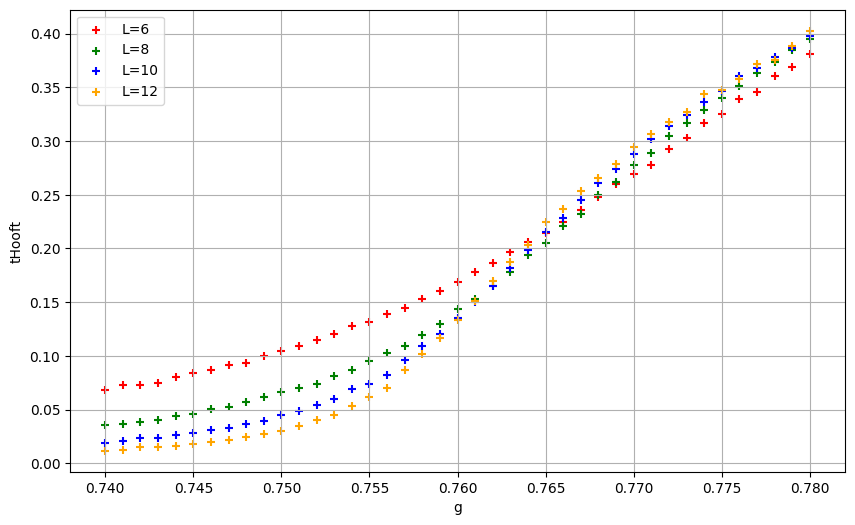

In [3]:
file_path = './data_to_analyze/Z2_new_tHooft_expects_test.csv'
plot_data(file_path, 'L', 'tHooft', 'g', x_min=0.72, x_max=0.78, L_subset=[6,8,10,12])

In [4]:
# Note the following relations between various quantities 
# a = 1/nu = d - Delta_epsilon = 3 - Delta_epsilon = 1.58738 
# b = 2 beta/nu = 2 Delta_sigma = 1.03629

In [5]:
def plot_rescaled_data(csv_file, L_column, Q_column, T_column, gc, delta_epsilon, delta_sigma, x_min=None, x_max=None, L_subset=None):
    df = pd.read_csv(csv_file)

    df['t'] = (df[T_column] - gc)/gc   #for Z2 data 
    a = 3 - delta_epsilon
    b = 2 * delta_sigma
    
    df['rescaled_x'] = df['t'] * df[L_column] ** (a)
    df['rescaled_y'] = df[Q_column] * df[L_column] ** (b)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Create a second x-axis that shares the same y-axis
    ax2 = ax1.twiny()

    colors = ["red", "green", "blue", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"]
    L_values = L_subset if L_subset else sorted(df[L_column].unique())

    for idx, L in enumerate(L_values):
        subset = df[df[L_column] == L]
        if x_min is not None and x_max is not None:
            subset = subset[(subset['rescaled_x'] >= x_min) & (subset['rescaled_x'] <= x_max)]
        color_idx = idx % len(colors)
        ax1.scatter(subset['rescaled_x'], subset['rescaled_y'], marker='+', color=colors[color_idx], label=f'L={L}')

    ax1.set_xlabel(f'Rescaled {T_column}')
    ax1.set_ylabel(f'Rescaled {Q_column}')
    ax1.grid(True)
    ax1.legend()

    # Set the labels for the top x-axis
    # This requires mapping the rescaled_x values back to the original T values
    # Here, we calculate the unscaled T values
    # This calculation should be adjusted according to how T relates to rescaled_x
    ax2.set_xticks(ax1.get_xticks())
    ax2.set_xbound(ax1.get_xbound())
    ax2.set_xlabel(f'{T_column}')

    ax2.set_xticklabels([f"{(x*gc/(L**(a)) + gc):.3g}" for x in ax1.get_xticks()])                #for Z2 data

    plt.title('Rescaled Data Plot')
    plt.show()

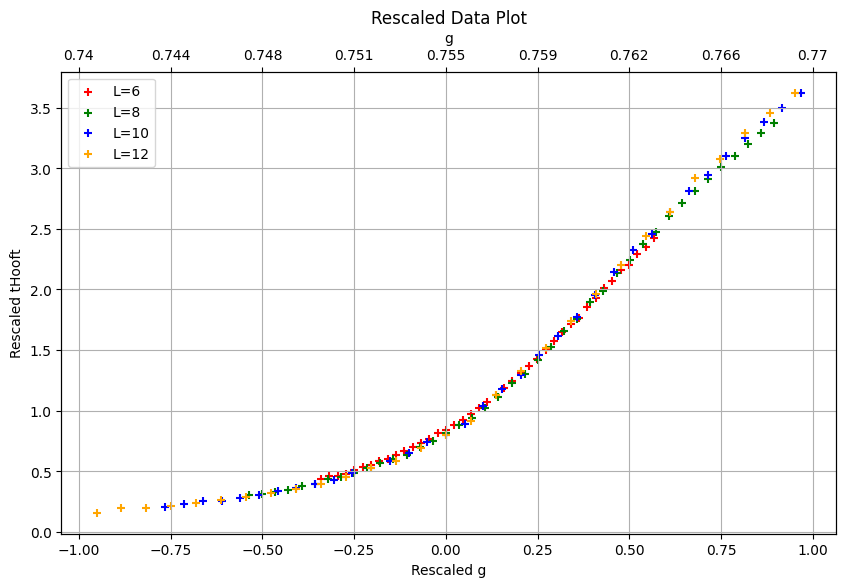

In [6]:
plot_rescaled_data(file_path, 'L', 'tHooft', 'g', gc=0.755,delta_epsilon=1.415, delta_sigma=0.516,x_min=-1, x_max=1, L_subset=[6,8,10,12])

In [7]:
from scipy.interpolate import interp1d

def collapse_measure(params, df, L_column, Q_column, T_column, x_min, x_max, L_subset, power=1.0, debug=False):
    gc, delta_epsilon, delta_sigma = params
    df['t'] = (df[T_column] - gc) / gc  # Calculate reduced temperature 't'
    a = 3 - delta_epsilon
    b = 2 * delta_sigma

    df['rescaled_x'] = df['t'] * df[L_column] ** a  # Scale x by L^a
    df['rescaled_y'] = df[Q_column] * df[L_column] ** b  # Scale y by L^b

    all_residuals = []
    for L1 in L_subset:
        for L2 in L_subset:
            if L1 != L2:
                subset1 = df[df[L_column] == L1]
                subset2 = df[df[L_column] == L2]
                valid_data1 = subset1[(subset1['rescaled_x'] >= x_min) & (subset1['rescaled_x'] <= x_max)]
                valid_data2 = subset2[(subset2['rescaled_x'] >= x_min) & (subset2['rescaled_x'] <= x_max)]

                if not valid_data1.empty and not valid_data2.empty:
                    # Handle duplicates by averaging over y
                    valid_data2 = valid_data2.groupby('rescaled_x')['rescaled_y'].mean().reset_index()

                    # Use linear interpolation if there are not enough points for cubic
                    kind = 'cubic' if len(valid_data2) > 3 else 'linear'
                    interp_func = interp1d(valid_data2['rescaled_x'], valid_data2['rescaled_y'], kind=kind,
                                           fill_value='extrapolate', bounds_error=False)

                    if debug:
                        print(f"Debugging info for L2 = {L2}: Number of points = {len(valid_data2)}, Interpolation kind = {kind}")

                    for xi, yi in zip(valid_data1['rescaled_x'], valid_data1['rescaled_y']):
                        if x_min <= xi <= x_max:
                            interpolated_yi = interp_func(xi)
                            residual = np.abs(yi - interpolated_yi) ** power
                            all_residuals.append(residual)

    normalized_residual = np.mean(all_residuals) ** (1 / power)

    return normalized_residual


In [8]:
params = (0.755, 1.415, 0.516)
df = pd.read_csv(file_path)
collapse_measure(params, df, 'L', 'tHooft', 'g',x_min=-1, x_max=1, L_subset=[8,10,12], power=1.0, debug=False)

0.11065214366626723

In [9]:
collapse_measure(params, df, 'L', 'tHooft', 'g',x_min=-1, x_max=1, L_subset=[8,10,12], power=1.0, debug=True)

Debugging info for L2 = 10: Number of points = 35, Interpolation kind = cubic
Debugging info for L2 = 12: Number of points = 29, Interpolation kind = cubic
Debugging info for L2 = 8: Number of points = 41, Interpolation kind = cubic
Debugging info for L2 = 12: Number of points = 29, Interpolation kind = cubic
Debugging info for L2 = 8: Number of points = 41, Interpolation kind = cubic
Debugging info for L2 = 10: Number of points = 35, Interpolation kind = cubic


0.11065214366626723

In [10]:
from scipy.optimize import least_squares

def compute_dimensions(args):
    df, L_column, Q_column, T_column, x_min, x_max, L_subset, power, initial_guess, bounds = args
    result = least_squares(
        collapse_measure,
        initial_guess,
        args=(df, L_column, Q_column, T_column, x_min, x_max, L_subset, power),
        bounds=bounds
    )
    return result.x

# we can perform statistical bootstrapping of our original dataset to obtain uncertainities 

# note that since we are sampling with replacement it is essential to pick x_min and x_max 
# such that even for the largest length in L_subset there are enough points for iterpolation
# given the data we have the lowest suggest width is [-0.5,0.5], but [-1,1] works even better
# to investigate this in detail turn the debug flag on in collapse_measure function  

def bootstrap_iteration(args, debug=False):
    df, L_column, Q_column, T_column, x_min, x_max, L_subset, power, initial_guess, bounds = args
    sampled_df = df.sample(frac=1.0, replace=True, random_state=np.random.RandomState())
    if debug:
        print(f"Sampled indices: {sampled_df.index.tolist()[:5]}")  # Print first 5 indices of the sampled data # this is to verify that there is enough randomness in bootstrap sampling  
        #print(f"Number of unique indices: {sampled_df.index.nunique()}")
        #print(f"Total number of indices: {len(sampled_df.index)}")
    args = sampled_df, L_column, Q_column, T_column, x_min, x_max, L_subset, power, initial_guess, bounds
    return compute_dimensions(args)

In [11]:
initial_guess = [0.755, 1.415, 0.516]  # Example initial guesses for gc, delta_epsilon, delta_sigma
bounds = ([0.75, 1.40, 0.50], [0.76, 1.45, 0.53])  # Bounds for the parameters
df = pd.read_csv(file_path)
args = (df, 'L', 'tHooft', 'g', -1, 1, [8,10,12], 1.0, initial_guess, bounds)

compute_dimensions(args)

array([0.75469853, 1.41500192, 0.51597596])

In [12]:
args = (df, 'L', 'tHooft', 'g', -1.0, 1.0, [8,10,12], 1.0, initial_guess, bounds)
bootstrap_iteration(args, debug=True)

Sampled indices: [158, 152, 100, 199, 21]


array([0.75484286, 1.41885777, 0.50715205])

In [13]:
from joblib import Parallel, delayed  # we use joblib instead of built-in python parallel threading since it is better at handling random seeds in parallel 

def bootstrap_params(df, L_column, Q_column, T_column, initial_guess, bounds, x_min, x_max, L_subset, power, n_iterations=10): # 100 bootstrap iterations is sufficient to estimate the standard deviations 
    args = [(df, L_column, Q_column, T_column, x_min, x_max, L_subset, power, initial_guess, bounds) for _ in range(n_iterations)]
    
    # Use Joblib Parallel to manage independent processes
    results = Parallel(n_jobs=-1)(delayed(bootstrap_iteration)(arg, debug=False) for arg in args)
    param_samples = np.array(results)

    mean_params = np.mean(param_samples, axis=0)
    std_params = np.std(param_samples, axis=0)

    mean_params = np.round(mean_params, 5)
    std_params = np.round(std_params, 5)

    print("gc, delta_epsilon, delta_sigma:", mean_params)
    print("err_gc, err_epsilon, err_sigma:", std_params)
    return mean_params, std_params


In [14]:
initial_guess = [0.755, 1.415, 0.516]  # Example initial guesses for gc, delta_epsilon, delta_sigma
bounds = ([0.75, 1.40, 0.50], [0.76, 1.45, 0.53])  # Bounds for the parameters
df = pd.read_csv(file_path)

# this takes a while to run since there are many optimizations being performed 
mean_params, std_params = bootstrap_params(df, 'L', 'tHooft', 'g', initial_guess, bounds, x_min=-1.0, x_max=1.0, L_subset=[8,10,12], power=1.0, n_iterations=10)

gc, delta_epsilon, delta_sigma: [0.75462 1.41658 0.51494]
err_gc, err_epsilon, err_sigma: [0.00014 0.00429 0.00252]


In [15]:
initial_guess = [0.755, 1.415, 0.516]  # Example initial guesses for gc, delta_epsilon, delta_sigma
bounds = ([0.75, 1.40, 0.50], [0.76, 1.45, 0.53])  # Bounds for the parameters
df = pd.read_csv(file_path)

# this takes a while to run since there are many optimizations being performed 
# mean_params, std_params = bootstrap_params(df, 'L', 'tHooft', 'g', initial_guess, bounds, x_min=-1.0, x_max=1.0, L_subset=[8,10,12], power=1.0, n_iterations=100)

In [16]:
# this takes a while to run since there are many optimizations being performed 
mean_params, std_params = bootstrap_params(df, 'L', 'tHooft', 'g', initial_guess, bounds, x_min=-1.0, x_max=1.0, L_subset=[8,10,12], power=1.0, n_iterations=200)

gc, delta_epsilon, delta_sigma: [0.75441 1.41694 0.51402]
err_gc, err_epsilon, err_sigma: [0.00082 0.00739 0.00404]


In [17]:
# results from 100 bootstrap iterations 
# gc, delta_epsilon, delta_sigma: [0.75341 1.42110 0.51476]
# err_gc, err_epsilon, err_sigma: [0.00289 0.01227 0.00569]

# for 200 iterations 
# # gc, delta_epsilon, delta_sigma: [0.75441 1.41694 0.51402]
# err_gc, err_epsilon, err_sigma: [0.00082 0.00739 0.00404]